In [ ]:
from numpy import asarray
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
from io import BytesIO
from google.colab import files
import matplotlib.image as mpimg

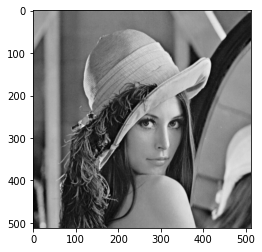

In [ ]:
image=cv.imread('watermarked_image.png',0)
plt.imshow(image,cmap='gray')

In [ ]:
#Converting int to float
gray_img=image.astype('float32')

print(gray_img)
gray_img.shape

gray_img=gray_img/255.0
gray_img

[[169. 169. 168. ... 175. 162. 138.]
 [169. 169. 168. ... 175. 162. 138.]
 [169. 169. 168. ... 175. 162. 138.]
 ...
 [ 53.  53.  59. ... 115. 112. 114.]
 [ 53.  53.  64. ... 117. 118. 122.]
 [ 53.  53.  64. ... 117. 118. 122.]]


array([[0.6627451 , 0.6627451 , 0.65882355, ..., 0.6862745 , 0.63529414,
        0.5411765 ],
       [0.6627451 , 0.6627451 , 0.65882355, ..., 0.6862745 , 0.63529414,
        0.5411765 ],
       [0.6627451 , 0.6627451 , 0.65882355, ..., 0.6862745 , 0.63529414,
        0.5411765 ],
       ...,
       [0.20784314, 0.20784314, 0.23137255, ..., 0.4509804 , 0.4392157 ,
        0.44705883],
       [0.20784314, 0.20784314, 0.2509804 , ..., 0.45882353, 0.4627451 ,
        0.47843137],
       [0.20784314, 0.20784314, 0.2509804 , ..., 0.45882353, 0.4627451 ,
        0.47843137]], dtype=float32)

In [ ]:
print('Min: %.3f,Max: %.3f'%(gray_img.min(),gray_img.max()))

Min: 0.153,Max: 0.961


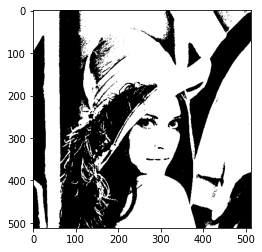

In [ ]:
#Converting to Binary Image
_,BG=cv.threshold(gray_img,0.5,1,cv.THRESH_BINARY)
plt.imshow(BG,cmap='gray')

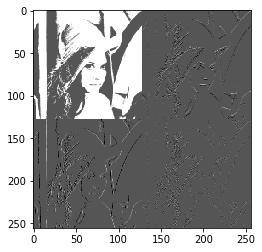

In [ ]:
import numpy as np
import pywt

#APPLYING DWT

npImage=BG
#LEVEL 1
data = np.array(npImage, dtype=np.float64)
coeffs1 = pywt.dwt2(data, 'haar')
LL1, (LH1, HL1, HH1) = coeffs1


#LEVEL 2
#data = np.array(npImage, dtype=np.float64)
coeffs2 = pywt.dwt2(LL1, 'haar')
LL2, (LH2, HL2, HH2) = coeffs2

#Copying LL2 into LL3
#LL3=LL2
#HL3=HL2
#LH3=LH2
#HH3=HH2

AH = np.concatenate([LL2, LH2], axis=1)
VD = np.concatenate([HL2, HH2], axis=1)
img0 = np.concatenate([AH, VD], axis=0)
plt.imshow(img0,cmap='gray',interpolation='nearest')

In [ ]:
#Function to scramble image
def catmap(frame,n):
  s=frame.shape
  pic= np.zeros(s,np.uint8)
  A=np.array([[2,1],[1,1]])
  ind=A@np.indices(s).reshape(2,-1)%(np.array(s)[:,None])
  pic[ind[0],ind[1]]=frame.reshape(-1)

  return pic
  
#Function to descramble image
def invcatmap(frame,n):
  s=frame.shape
  pic= np.zeros(s,np.uint8)
  A=np.array([[1,-1],[-1,2]])
  ind=A@np.indices(s).reshape(2,-1)%(np.array(s)[:,None])
  pic[ind[0],ind[1]]=frame.reshape(-1)

  return pic

In [ ]:
#SPLITTING THE IMAGE OF 128X128 INTO A MATRIX OF 16X16 TILES

arr = np.asarray(LL2)
arr = np.split(arr, 16)
arr = np.array([np.split(x, 16, 1) for x in arr])

In [ ]:
#CONVERTING THE MATRIX OF TILES INTO A LIST TO COMPUTE SVD

arr1=[]
for z1 in range(16):
  for z2 in range(16):
    arr1.append(arr[z1][z2])

In [ ]:
from scipy.linalg import svd

#APPLYING THE SVD 
U=[0 for x in range(256)]
S=[0 for x in range(256)]
VT=[0 for x in range(256)]
for x1 in range(256):
  U[x1],S[x1],VT[x1]=svd(arr1[x1])


In [ ]:
#EXTRACTING THE MAX VALUES FROM THE DIAGONAL MATRIX 

S1=[]
for z1 in range(256):
  S1.append(max(S[z1]))

In [ ]:
#THE MAX SINGULAR VALUE ACCUMULATED TOGETHER FORMS UP THE FEATURE IMAGE
image=np.array(S1)
image=image.reshape(16,16)


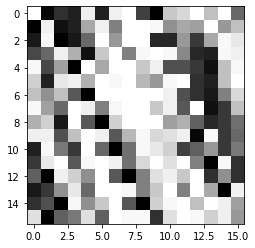

In [ ]:

#PLOTTING THE SCRAMBLED WATERMARKED IMAGE
scrambled_watermarkimage=catmap(image,100)
plt.imshow(scrambled_watermarkimage,cmap='gray')


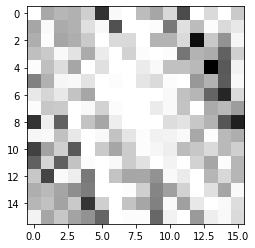

In [ ]:
#LOADING AND PLOTTING THE ZERO-WATERMARK

zero_watermark=cv.imread('zero_watermark.png',0)
plt.imshow(zero_watermark,cmap='gray')

In [ ]:
scrambled_image=cv.imread('scrambled_image.png',0)


In [ ]:
#APLLYING LINEAR COMBINATION TO OBTAIN THE SCRAMBLED WATERMARK

scrambled_watermark=0.05*scrambled_image  + 0.95*zero_watermark

#scrambled_watermark=  (zero_watermark) ** (scrambled_image)

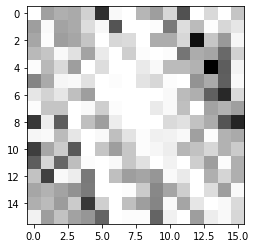

In [ ]:
#PLOTTING THE SCRAMBLED WATERMARK IMAGE
plt.imshow(scrambled_watermark,cmap='gray')

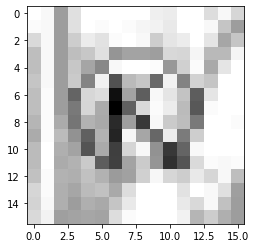

In [ ]:
#APPLYING THE CAT MAPPING TO GET THE ORIGINAL WATERMARK BACK
watermark=invcatmap(scrambled_watermark,100)
plt.imshow(watermark,cmap='gray')

In [ ]:
#SIMILAIRTY CHECKING BETWEEN THE ORIGINAL WATERMARK AND THE EXTRACTED WATERMARK

from skimage.metrics import structural_similarity as ssim
logo=cv.imread('logo1.png',0)
comparison_value=ssim(logo,watermark)
print('The Similarity Score is: %.2f'%(comparison_value))

The Similarity Score is: 0.77


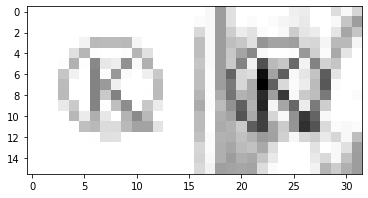

In [ ]:
AH = np.concatenate([logo, watermark], axis=1)
plt.imshow(AH,cmap='gray',interpolation='nearest')